# Time Series - TensorFlow
Provincial with no series manipulation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

## Activation functions

In [5]:
x = np.arange(-5, 5, 0.01)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return 2 / (1 + np.exp(-2 * x)) -1

def softmax(x):
    return np.exp(x) / float(sum(np.exp(x)))

relu = np.vectorize(lambda x: x if x > 0 else 0, otypes=[np.float])
leaky_relu = np.vectorize(lambda x: max(0.1 * x, x), otypes=[np.float])

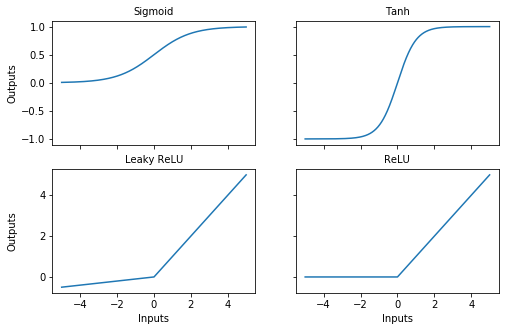

In [6]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(8,5))
(ax1, ax2), (ax3, ax4) = axs
ax1.plot(x, sigmoid(x))
ax2.plot(x, tanh(x))
ax3.plot(x, leaky_relu(x))
ax4.plot(x, relu(x))

axs[0, 0].set_title('Sigmoid', fontsize=10)
axs[0, 1].set_title('Tanh', fontsize=10)
axs[1, 0].set_title('Leaky ReLU', fontsize=10)
axs[1, 1].set_title('ReLU', fontsize=10)

for ax in axs.flat:
    ax.set(xlabel='Inputs', ylabel='Outputs')
    ax.label_outer()

fig.align_ylabels(axs[:, 0])

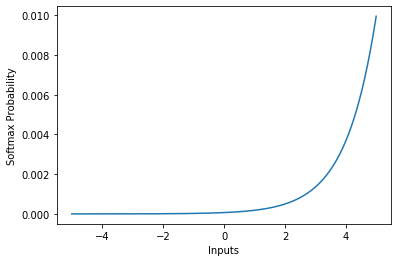

In [7]:
plt.plot(x, softmax(x))
plt.xlabel("Inputs")
plt.ylabel("Softmax Probability")
plt.show()

## Load data

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [6]:
df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')

In [7]:
df = df.set_index(date)

In [8]:
df = df.loc[:, ['New_cases', 'Deaths']]

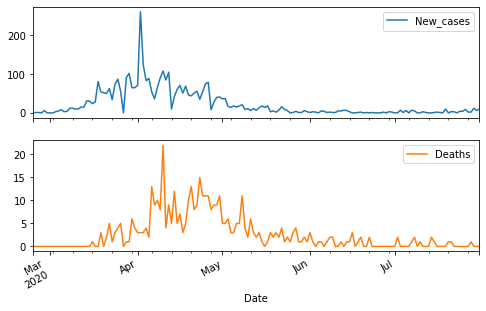

In [9]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,159.0,22.817610,34.652498,0.0,1.0,7.0,35.5,261.0
Deaths,159.0,2.622642,3.742806,0.0,0.0,1.0,3.5,22.0


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [13]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [14]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [15]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0582 - mean_squared_error: 0.0064


In [16]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [17]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['New_cases']

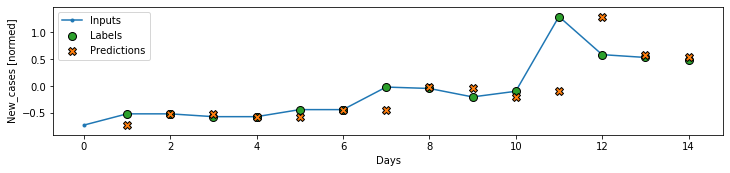

In [18]:
wide_window.plot(baseline)

In [19]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [20]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 57ms/step - loss: 1.9772 - mean_absolute_error: 1.0248 - mean_squared_error: 1.9772 - val_loss: 0.7221 - val_mean_absolute_error: 0.8202 - val_mean_squared_error: 0.7221
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 1.9617 - mean_absolute_error: 1.0201 - mean_squared_error: 1.9617 - val_loss: 0.7114 - val_mean_absolute_error: 0.8139 - val_mean_squared_error: 0.7114
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 1.9481 - mean_absolute_error: 1.0153 - mean_squared_error: 1.9481 - val_loss: 0.7018 - val_mean_absolute_error: 0.8081 - val_mean_squared_error: 0.7018
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 1.9347 - mean_absolute_error: 1.0107 - mean_squared_error: 1.9347 - val_loss: 0.6923 - val_mean_absolute_error: 0.8025 - val_mean_squared_error: 0.6923
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 1.9205 - mean_absolute_error: 1.0060 

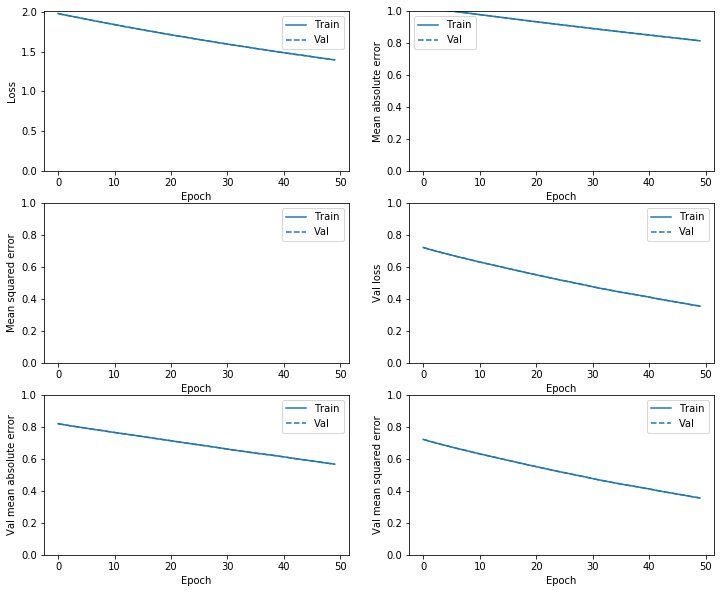

In [21]:
plot_metrics(history)

In [22]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.3555 - mean_absolute_error: 0.5668 - mean_squared_error: 0.3555


In [23]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

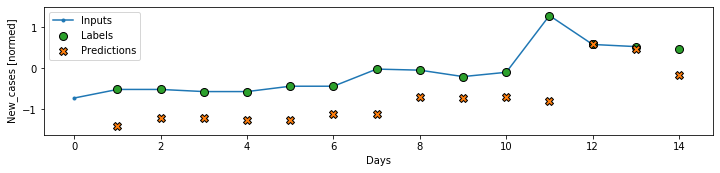

In [24]:
wide_window.plot(linear)

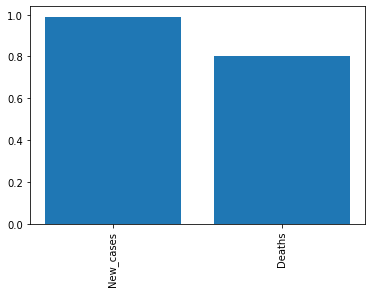

In [25]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [26]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 40ms/step - loss: 0.9696 - mean_absolute_error: 0.7888 - mean_squared_error: 0.9696 - val_loss: 0.8817 - val_mean_absolute_error: 0.9370 - val_mean_squared_error: 0.8817
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 0.8141 - mean_absolute_error: 0.6861 - mean_squared_error: 0.8141 - val_loss: 0.6052 - val_mean_absolute_error: 0.7759 - val_mean_squared_error: 0.6052
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: 0.6917 - mean_absolute_error: 0.5991 - mean_squared_error: 0.6917 - val_loss: 0.4166 - val_mean_absolute_error: 0.6431 - val_mean_squared_error: 0.4166
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 0.6189 - mean_absolute_error: 0.5460 - mean_squared_error: 0.6189 - val_loss: 0.2741 - val_mean_absolute_error: 0.5205 - val_mean_squared_error: 0.2741
Epoch 5/50
4/4 [==============================] - 0s 12ms/step - loss: 0.5666 - mean_absolute_error: 0.4937 

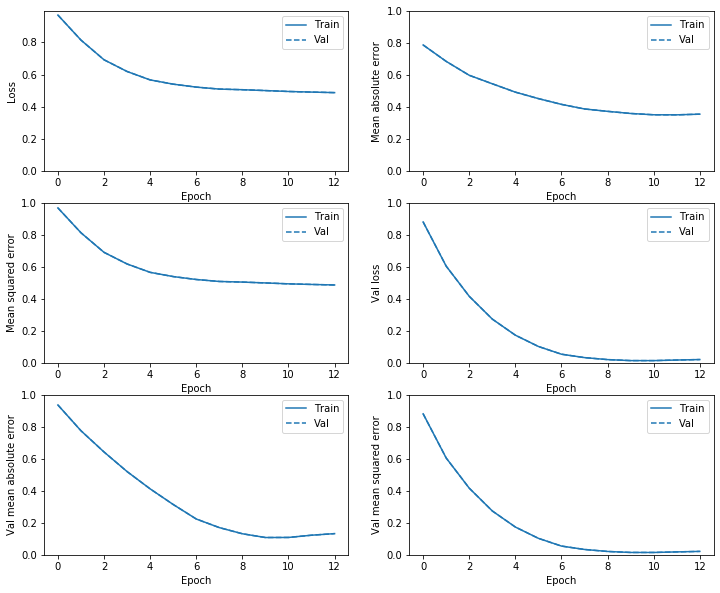

In [27]:
plot_metrics(history)

In [28]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 944us/step - loss: 0.0213 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0213


In [29]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [30]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['New_cases']

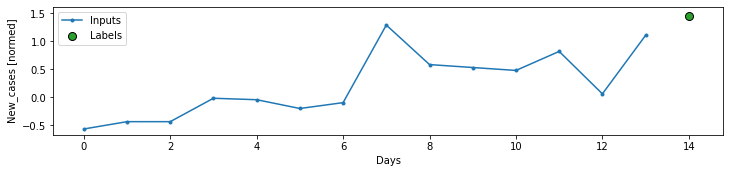

In [31]:
conv_window.plot()

In [32]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [33]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 1.1655 - mean_absolute_error: 0.8010 - mean_squared_error: 1.1655 - val_loss: 0.3714 - val_mean_absolute_error: 0.6018 - val_mean_squared_error: 0.3714
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 0.9704 - mean_absolute_error: 0.7032 - mean_squared_error: 0.9704 - val_loss: 0.2867 - val_mean_absolute_error: 0.5281 - val_mean_squared_error: 0.2867
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8590 - mean_absolute_error: 0.6460 - mean_squared_error: 0.8590 - val_loss: 0.2110 - val_mean_absolute_error: 0.4515 - val_mean_squared_error: 0.2110
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.7673 - mean_absolute_error: 0.5992 - mean_squared_error: 0.7673 - val_loss: 0.1610 - val_mean_absolute_error: 0.3921 - val_mean_squared_error: 0.1610
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.7070 - mean_absolute_error: 0.5525 

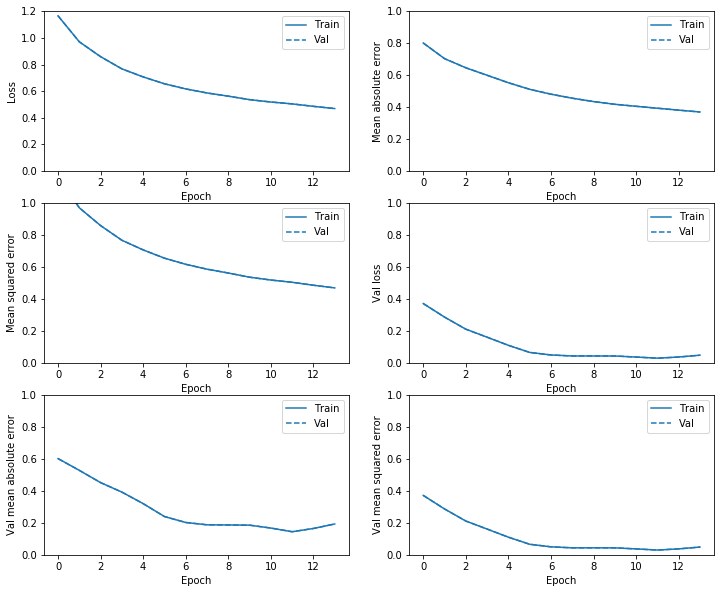

In [34]:
plot_metrics(history)

In [35]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 922us/step - loss: 0.0484 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0484


In [36]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

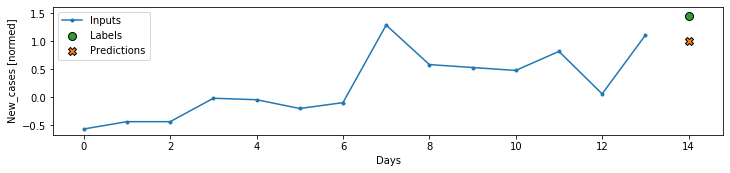

In [37]:
conv_window.plot(multi_step_dense)

In [38]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [39]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 147ms/step - loss: 1.2495 - mean_absolute_error: 0.8644 - mean_squared_error: 1.2495 - val_loss: 0.8776 - val_mean_absolute_error: 0.9347 - val_mean_squared_error: 0.8776
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.1336 - mean_absolute_error: 0.8126 - mean_squared_error: 1.1336 - val_loss: 0.7646 - val_mean_absolute_error: 0.8722 - val_mean_squared_error: 0.7646
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0383 - mean_absolute_error: 0.7636 - mean_squared_error: 1.0383 - val_loss: 0.6607 - val_mean_absolute_error: 0.8098 - val_mean_squared_error: 0.6607
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 0.9511 - mean_absolute_error: 0.7173 - mean_squared_error: 0.9511 - val_loss: 0.5721 - val_mean_absolute_error: 0.7517 - val_mean_squared_error: 0.5721
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8763 - mean_absolute_error: 0.6746

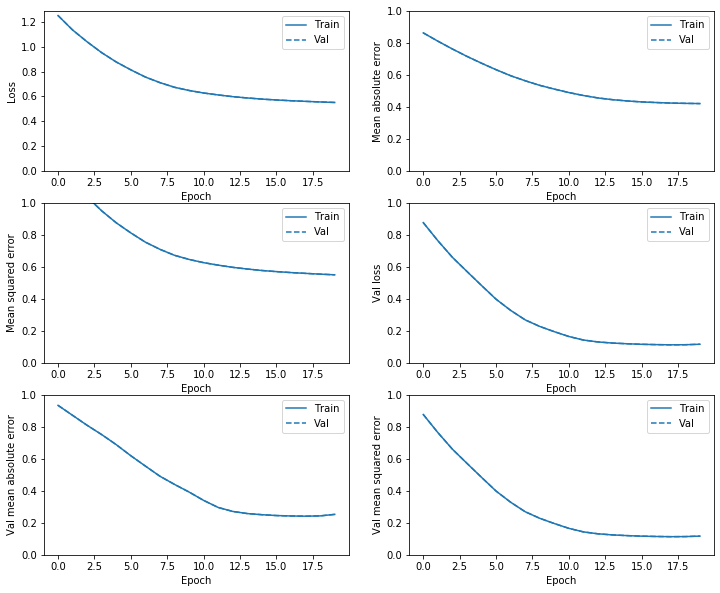

In [40]:
plot_metrics(history)

In [41]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 972us/step - loss: 0.1168 - mean_absolute_error: 0.2528 - mean_squared_error: 0.1168


In [42]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

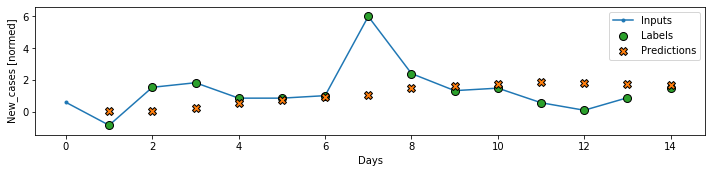

In [43]:
wide_window.plot(lstm_model)

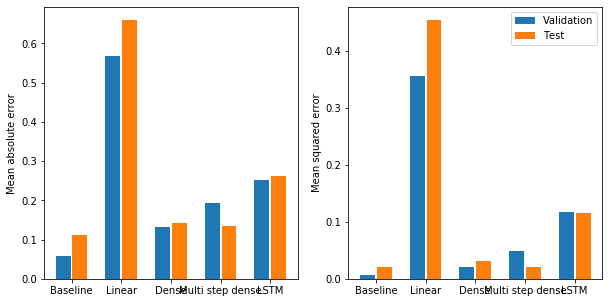

In [44]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

### Multi-output

In [45]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [46]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [47]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 910us/step - loss: 0.0400 - mean_absolute_error: 0.1137 - mean_squared_error: 0.0400


In [48]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

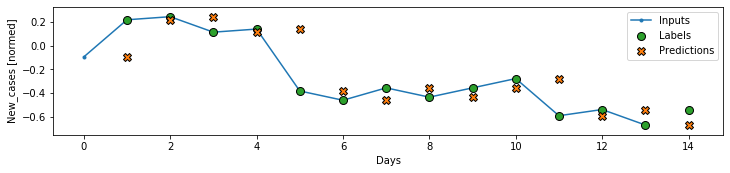

In [49]:
wide_window.plot(baseline, plot_col=compart)

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [51]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 48ms/step - loss: 0.8984 - mean_absolute_error: 0.7021 - mean_squared_error: 0.8984 - val_loss: 0.4052 - val_mean_absolute_error: 0.6161 - val_mean_squared_error: 0.4052
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 0.7996 - mean_absolute_error: 0.6462 - mean_squared_error: 0.7996 - val_loss: 0.3080 - val_mean_absolute_error: 0.5333 - val_mean_squared_error: 0.3080
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 0.7073 - mean_absolute_error: 0.5939 - mean_squared_error: 0.7073 - val_loss: 0.2297 - val_mean_absolute_error: 0.4549 - val_mean_squared_error: 0.2297
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6427 - mean_absolute_error: 0.5492 - mean_squared_error: 0.6427 - val_loss: 0.1621 - val_mean_absolute_error: 0.3803 - val_mean_squared_error: 0.1621
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.5904 - mean_absolute_error: 0.5062 

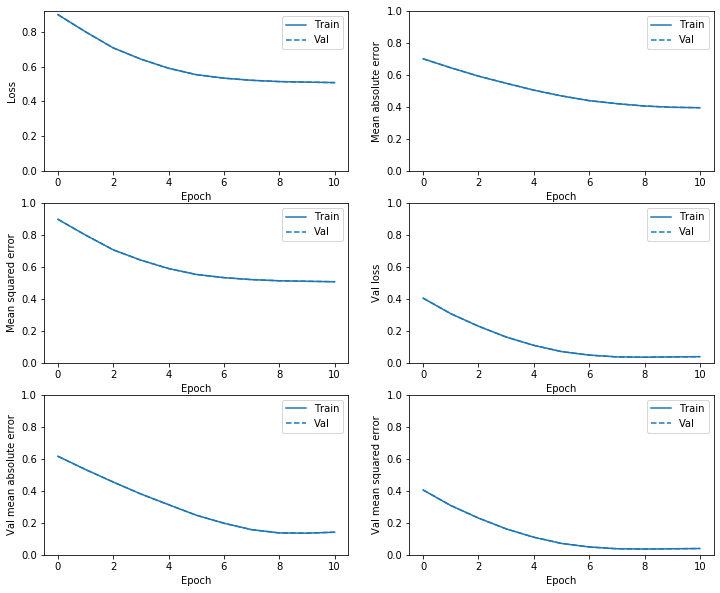

In [52]:
plot_metrics(history)

In [53]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 890us/step - loss: 0.0393 - mean_absolute_error: 0.1413 - mean_squared_error: 0.0393


In [54]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

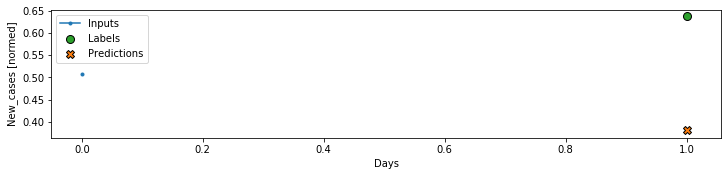

In [55]:
single_step_window.plot(dense, plot_col=compart)

In [56]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
4/4 [==============================] - 0s 124ms/step - loss: 1.2796 - mean_absolute_error: 0.8718 - mean_squared_error: 1.2796 - val_loss: 0.9260 - val_mean_absolute_error: 0.9499 - val_mean_squared_error: 0.9260
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 1.2132 - mean_absolute_error: 0.8429 - mean_squared_error: 1.2132 - val_loss: 0.8538 - val_mean_absolute_error: 0.9117 - val_mean_squared_error: 0.8538
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 1.1531 - mean_absolute_error: 0.8155 - mean_squared_error: 1.1531 - val_loss: 0.8009 - val_mean_absolute_error: 0.8827 - val_mean_squared_error: 0.8009
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 1.1038 - mean_absolute_error: 0.7932 - mean_squared_error: 1.1038 - val_loss: 0.7564 - val_mean_absolute_error: 0.8575 - val_mean_squared_error: 0.7564
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1.0530 - mean_absolute_error: 0.7712

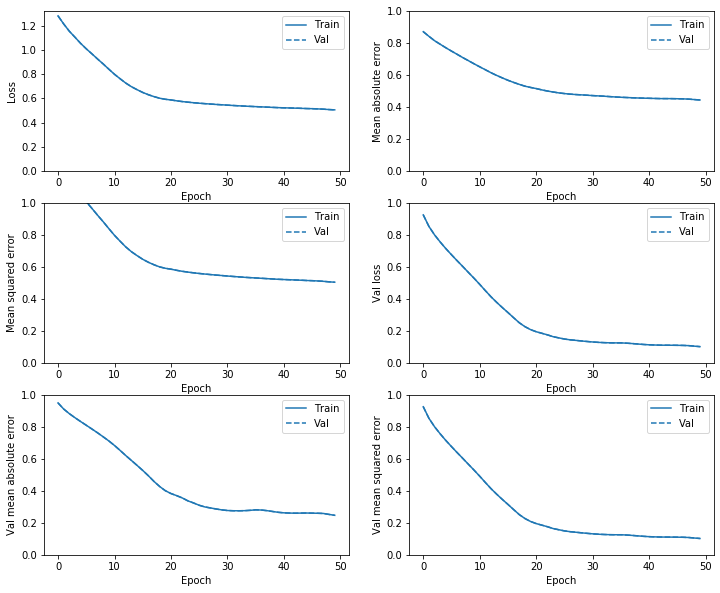

In [57]:
plot_metrics(history)

In [58]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.1020 - mean_absolute_error: 0.2470 - mean_squared_error: 0.1020


In [59]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

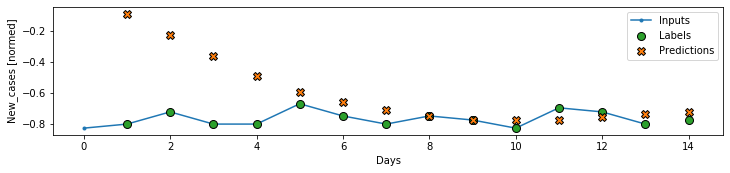

In [60]:
wide_window.plot(lstm_model, plot_col=compart)

In [61]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 209ms/step - loss: 0.7492 - mean_absolute_error: 0.4835 - mean_squared_error: 0.7492 - val_loss: 0.0400 - val_mean_absolute_error: 0.1170 - val_mean_squared_error: 0.0400
Epoch 2/50
4/4 [==============================] - 0s 28ms/step - loss: 0.7468 - mean_absolute_error: 0.4844 - mean_squared_error: 0.7468 - val_loss: 0.0401 - val_mean_absolute_error: 0.1196 - val_mean_squared_error: 0.0401
Epoch 3/50
4/4 [==============================] - 0s 28ms/step - loss: 0.7444 - mean_absolute_error: 0.4854 - mean_squared_error: 0.7444 - val_loss: 0.0403 - val_mean_absolute_error: 0.1221 - val_mean_squared_error: 0.0403


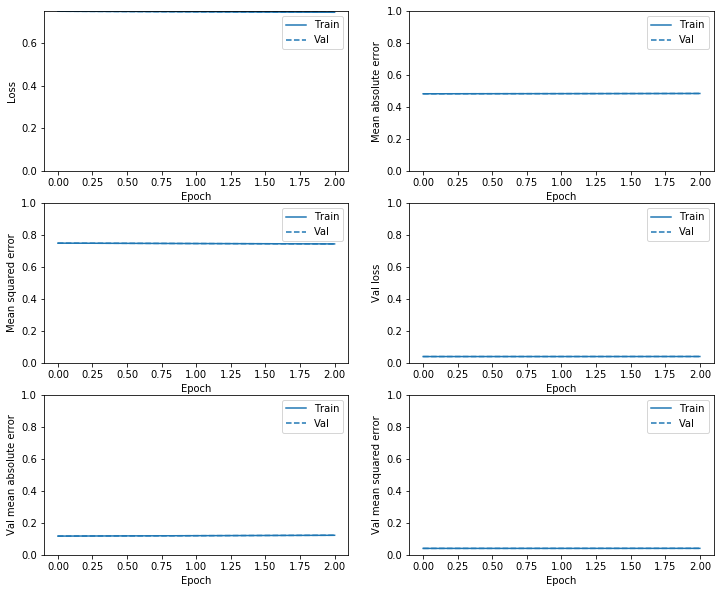

In [62]:
plot_metrics(history)

In [63]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0403 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0403


In [64]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

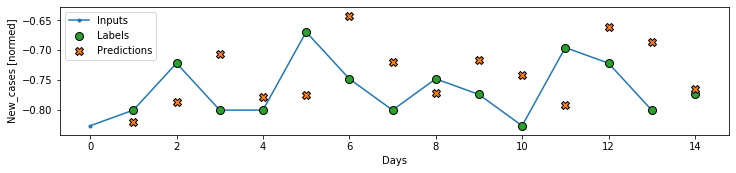

In [65]:
wide_window.plot(residual_lstm, plot_col=compart)

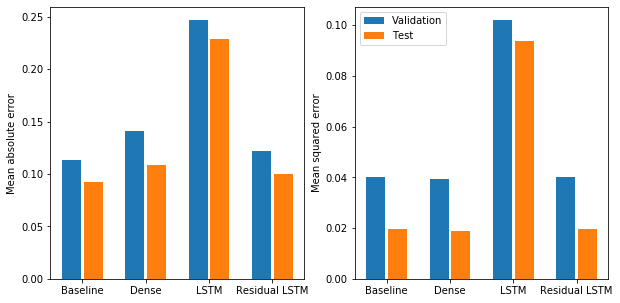

In [66]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

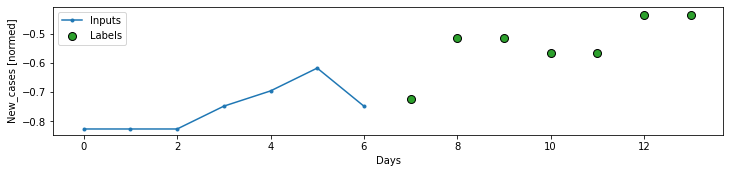

In [67]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot()

In [68]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [69]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

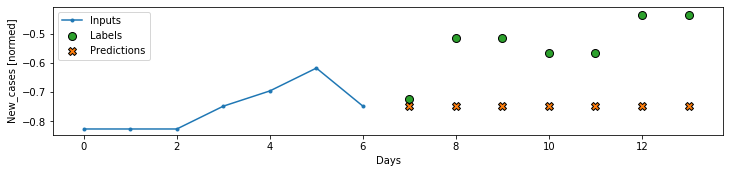

In [70]:
multi_window.plot(last_baseline)

In [71]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [72]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

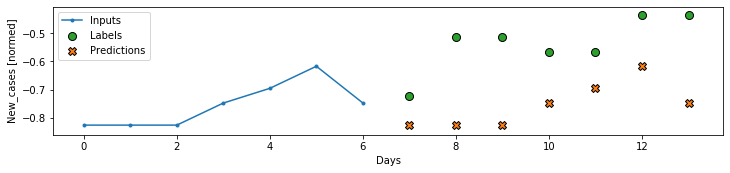

In [73]:
multi_window.plot(repeat_baseline)

### Single shot

In [74]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 49ms/step - loss: 1.0345 - mean_absolute_error: 0.7546 - mean_squared_error: 1.0345 - val_loss: 0.6117 - val_mean_absolute_error: 0.7712 - val_mean_squared_error: 0.6117
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 1.0269 - mean_absolute_error: 0.7511 - mean_squared_error: 1.0269 - val_loss: 0.6045 - val_mean_absolute_error: 0.7665 - val_mean_squared_error: 0.6045
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 1.0205 - mean_absolute_error: 0.7480 - mean_squared_error: 1.0205 - val_loss: 0.5983 - val_mean_absolute_error: 0.7625 - val_mean_squared_error: 0.5983
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 1.0139 - mean_absolute_error: 0.7448 - mean_squared_error: 1.0139 - val_loss: 0.5933 - val_mean_absolute_error: 0.7592 - val_mean_squared_error: 0.5933
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 1.0078 - mean_absolute_error: 0.7421 

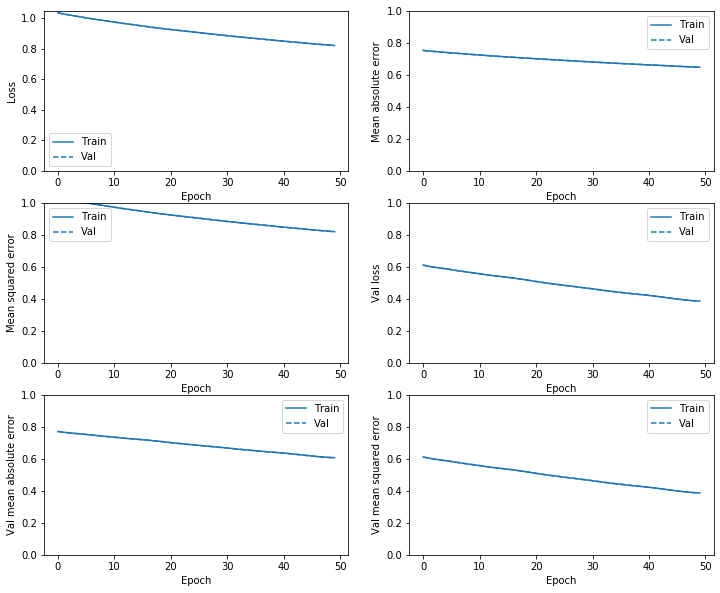

In [75]:
plot_metrics(history)

In [76]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.3870 - mean_absolute_error: 0.6074 - mean_squared_error: 0.3870


In [77]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

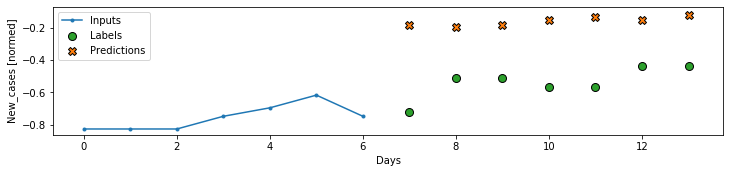

In [78]:
multi_window.plot(multi_linear_model)

In [79]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 54ms/step - loss: 1.0185 - mean_absolute_error: 0.7465 - mean_squared_error: 1.0185 - val_loss: 0.5396 - val_mean_absolute_error: 0.7229 - val_mean_squared_error: 0.5396
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.9491 - mean_absolute_error: 0.7110 - mean_squared_error: 0.9491 - val_loss: 0.4551 - val_mean_absolute_error: 0.6618 - val_mean_squared_error: 0.4551
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.8765 - mean_absolute_error: 0.6730 - mean_squared_error: 0.8765 - val_loss: 0.3716 - val_mean_absolute_error: 0.5949 - val_mean_squared_error: 0.3716
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 0.8081 - mean_absolute_error: 0.6362 - mean_squared_error: 0.8081 - val_loss: 0.2815 - val_mean_absolute_error: 0.5127 - val_mean_squared_error: 0.2815
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.7467 - mean_absolute_error: 0.6022 

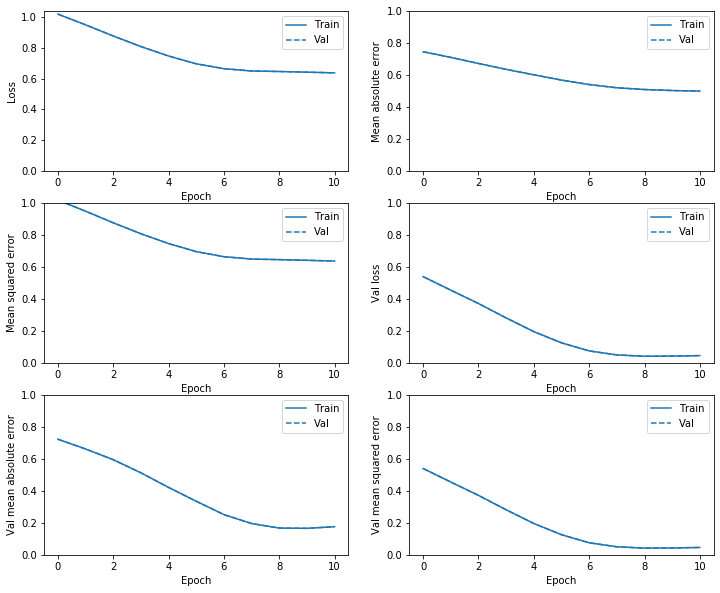

In [80]:
plot_metrics(history)

In [81]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0459 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0459


In [82]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

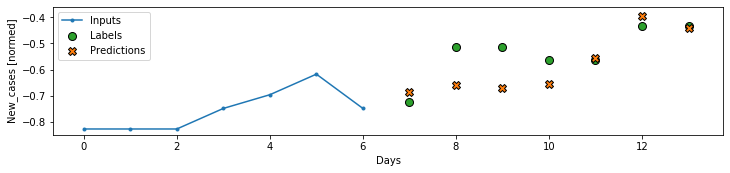

In [83]:
multi_window.plot(multi_dense_model)

In [84]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/50
4/4 [==============================] - 1s 221ms/step - loss: 1.0330 - mean_absolute_error: 0.7537 - mean_squared_error: 1.0330 - val_loss: 0.6050 - val_mean_absolute_error: 0.7668 - val_mean_squared_error: 0.6050
Epoch 2/50
4/4 [==============================] - 0s 25ms/step - loss: 1.0194 - mean_absolute_error: 0.7472 - mean_squared_error: 1.0194 - val_loss: 0.5898 - val_mean_absolute_error: 0.7568 - val_mean_squared_error: 0.5898
Epoch 3/50
4/4 [==============================] - 0s 30ms/step - loss: 1.0026 - mean_absolute_error: 0.7392 - mean_squared_error: 1.0026 - val_loss: 0.5732 - val_mean_absolute_error: 0.7458 - val_mean_squared_error: 0.5732
Epoch 4/50
4/4 [==============================] - 0s 37ms/step - loss: 0.9840 - mean_absolute_error: 0.7302 - mean_squared_error: 0.9840 - val_loss: 0.5550 - val_mean_absolute_error: 0.7335 - val_mean_squared_error: 0.5550
Epoch 5/50
4/4 [==============================] - 0s 32ms/step - loss: 0.9618 - mean_absolute_error: 0.7195

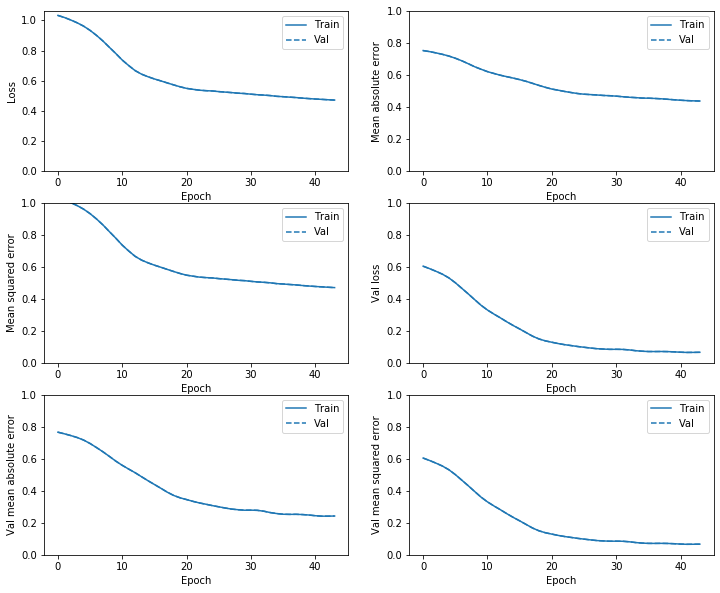

In [85]:
plot_metrics(history)

In [86]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0666 - mean_absolute_error: 0.2426 - mean_squared_error: 0.0666


In [87]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

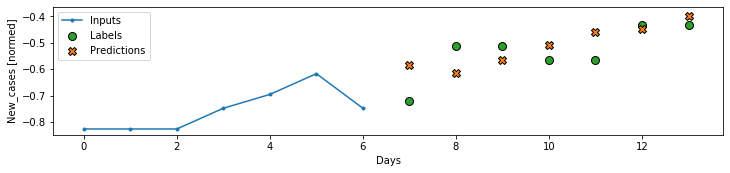

In [88]:
multi_window.plot(multi_lstm_model)

## AR model

In [89]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [90]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [91]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/50
4/4 [==============================] - 1s 129ms/step - loss: 1.1045 - mean_absolute_error: 0.7866 - mean_squared_error: 1.1045 - val_loss: 0.6557 - val_mean_absolute_error: 0.7988 - val_mean_squared_error: 0.6557
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 1.0308 - mean_absolute_error: 0.7571 - mean_squared_error: 1.0308 - val_loss: 0.6082 - val_mean_absolute_error: 0.7687 - val_mean_squared_error: 0.6082
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 0.9675 - mean_absolute_error: 0.7279 - mean_squared_error: 0.9675 - val_loss: 0.5502 - val_mean_absolute_error: 0.7300 - val_mean_squared_error: 0.5502
Epoch 4/50
4/4 [==============================] - 0s 30ms/step - loss: 0.9072 - mean_absolute_error: 0.6979 - mean_squared_error: 0.9072 - val_loss: 0.4909 - val_mean_absolute_error: 0.6879 - val_mean_squared_error: 0.4909
Epoch 5/50
4/4 [==============================] - 0s 32ms/step - loss: 0.8399 - mean_absolute_error: 0.6676

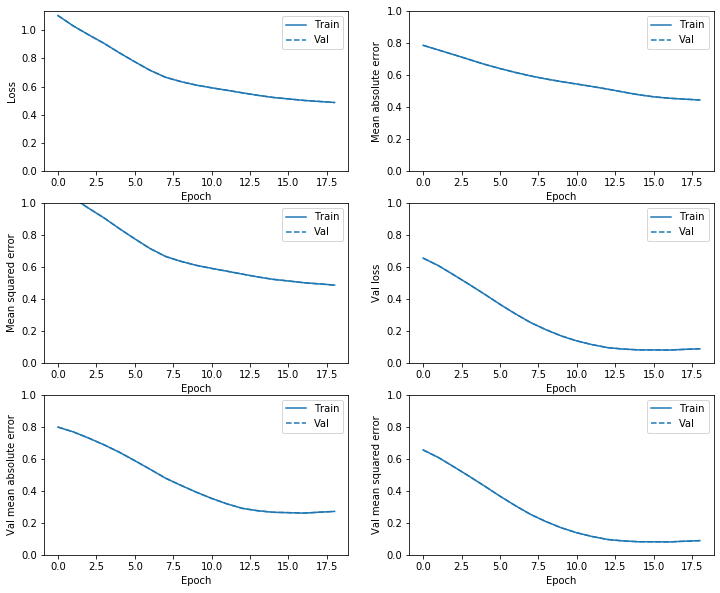

In [92]:
plot_metrics(history)

In [93]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0887 - mean_absolute_error: 0.2714 - mean_squared_error: 0.0887


In [94]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

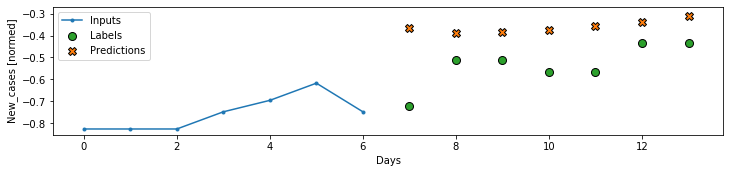

In [95]:
multi_window.plot(feedback_model)

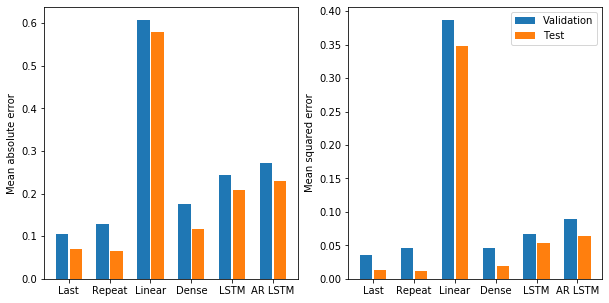

In [96]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance)